## 1. Import Libraries

In [23]:
import pandas as pd
import numpy as np
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# ตั้งค่าการแสดงผล
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', 200)

print(" Libraries imported successfully!")

 Libraries imported successfully!


## 2. กำหนด Paths

In [24]:
# กำหนด paths
DATA_RAW = "../data/raw"
DATA_PROCESSED = "../data/processed"

# สร้าง processed directory ถ้ายังไม่มี
os.makedirs(DATA_PROCESSED, exist_ok=True)

# แสดงไฟล์ที่มีอยู่
print(" ไฟล์ใน Raw Data Directory:")
for f in os.listdir(DATA_RAW):
    size_mb = os.path.getsize(os.path.join(DATA_RAW, f)) / (1024*1024)
    print(f"   - {f}: {size_mb:.1f} MB")

 ไฟล์ใน Raw Data Directory:
   - application_test.csv: 25.3 MB
   - application_train.csv: 158.4 MB
   - bureau.csv: 162.1 MB
   - bureau_balance.csv: 358.2 MB
   - credit_card_balance.csv: 404.9 MB
   - HomeCredit_columns_description.csv: 0.0 MB
   - installments_payments.csv: 689.6 MB
   - POS_CASH_balance.csv: 374.5 MB
   - previous_application.csv: 386.2 MB
   - sample_submission.csv: 0.5 MB


---
## 3. โหลดข้อมูล (Load Data)

In [25]:
# โหลด Application Data (หลัก)
print(" กำลังโหลด Application Train...")
app_train = pd.read_csv(os.path.join(DATA_RAW, "application_train.csv"))
print(f"   Application Train: {app_train.shape}")

print(" กำลังโหลด Application Test...")
app_test = pd.read_csv(os.path.join(DATA_RAW, "application_test.csv"))
print(f"   Application Test: {app_test.shape}")

print("\n โหลด Application Data เสร็จสิ้น!")

 กำลังโหลด Application Train...
   Application Train: (307511, 122)
 กำลังโหลด Application Test...
   Application Test: (48744, 121)

 โหลด Application Data เสร็จสิ้น!


In [26]:
# โหลดข้อมูลเสริม (Secondary Tables)
print(" กำลังโหลดข้อมูลเสริม...")

bureau = pd.read_csv(os.path.join(DATA_RAW, "bureau.csv"))
print(f"   Bureau: {bureau.shape}")

bureau_balance = pd.read_csv(os.path.join(DATA_RAW, "bureau_balance.csv"))
print(f"   Bureau Balance: {bureau_balance.shape}")

prev_app = pd.read_csv(os.path.join(DATA_RAW, "previous_application.csv"))
print(f"   Previous Application: {prev_app.shape}")

pos_cash = pd.read_csv(os.path.join(DATA_RAW, "POS_CASH_balance.csv"))
print(f"   POS CASH Balance: {pos_cash.shape}")

credit_card = pd.read_csv(os.path.join(DATA_RAW, "credit_card_balance.csv"))
print(f"   Credit Card Balance: {credit_card.shape}")

installments = pd.read_csv(os.path.join(DATA_RAW, "installments_payments.csv"))
print(f"   Installments Payments: {installments.shape}")

print("\n โหลดข้อมูลเสริมเสร็จสิ้น!")

 กำลังโหลดข้อมูลเสริม...
   Bureau: (1716428, 17)
   Bureau Balance: (27299925, 3)
   Previous Application: (1670214, 37)
   POS CASH Balance: (10001358, 8)
   Credit Card Balance: (3840312, 23)
   Installments Payments: (13605401, 8)

 โหลดข้อมูลเสริมเสร็จสิ้น!


---
## 4. Data Cleaning - Application Data

### 4.1 ตรวจสอบ Missing Values

In [27]:
def missing_value_summary(df, name="DataFrame"):
    """สรุปข้อมูล Missing Values"""
    missing = df.isnull().sum()
    missing_pct = 100 * df.isnull().sum() / len(df)
    
    missing_table = pd.DataFrame({
        'Missing Values': missing,
        'Percentage (%)': missing_pct
    })
    
    missing_table = missing_table[missing_table['Missing Values'] > 0]
    missing_table = missing_table.sort_values('Percentage (%)', ascending=False)
    
    print(f"\n Missing Values Summary: {name}")
    print(f"   Total Columns: {len(df.columns)}")
    print(f"   Columns with Missing: {len(missing_table)}")
    
    return missing_table

# ตรวจสอบ Missing Values ใน Application Train
missing_train = missing_value_summary(app_train, "Application Train")
print("\nTop 20 Columns with Missing Values:")
display(missing_train.head(20))


 Missing Values Summary: Application Train
   Total Columns: 122
   Columns with Missing: 67

Top 20 Columns with Missing Values:


,Missing Values,Percentage (%)
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_AVG,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


### 4.2 จัดการ DAYS_EMPLOYED Anomaly

In [28]:
# ตรวจสอบ DAYS_EMPLOYED anomaly
print(" DAYS_EMPLOYED Statistics (Before):")
print(app_train['DAYS_EMPLOYED'].describe())

# จำนวน anomaly (365243 = placeholder สำหรับค่าที่หายไป)
anomaly_count = (app_train['DAYS_EMPLOYED'] == 365243).sum()
print(f"\n Anomaly Count (365243): {anomaly_count} ({100*anomaly_count/len(app_train):.2f}%)")

 DAYS_EMPLOYED Statistics (Before):
count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

 Anomaly Count (365243): 55374 (18.01%)


In [29]:
def clean_days_employed(df):
    """แก้ไข DAYS_EMPLOYED anomaly"""
    df_clean = df.copy()
    
    # สร้าง flag สำหรับ anomaly
    df_clean['DAYS_EMPLOYED_ANOM'] = df_clean['DAYS_EMPLOYED'] == 365243
    
    # แทนที่ 365243 ด้วย NaN
    df_clean['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    return df_clean

# ทำความสะอาด Application Data
app_train_clean = clean_days_employed(app_train)
app_test_clean = clean_days_employed(app_test)

print(" DAYS_EMPLOYED anomaly ถูกแก้ไขแล้ว")
print(f"   DAYS_EMPLOYED_ANOM created (Train): {app_train_clean['DAYS_EMPLOYED_ANOM'].sum()} records")
print(f"   DAYS_EMPLOYED_ANOM created (Test): {app_test_clean['DAYS_EMPLOYED_ANOM'].sum()} records")

 DAYS_EMPLOYED anomaly ถูกแก้ไขแล้ว
   DAYS_EMPLOYED_ANOM created (Train): 55374 records
   DAYS_EMPLOYED_ANOM created (Test): 9274 records


 DAYS_EMPLOYED Statistics (After):
count    252137.000000
mean      -2384.169325
std        2338.360162
min      -17912.000000
25%       -3175.000000
50%       -1648.000000
75%        -767.000000
max           0.000000
Name: DAYS_EMPLOYED, dtype: float64


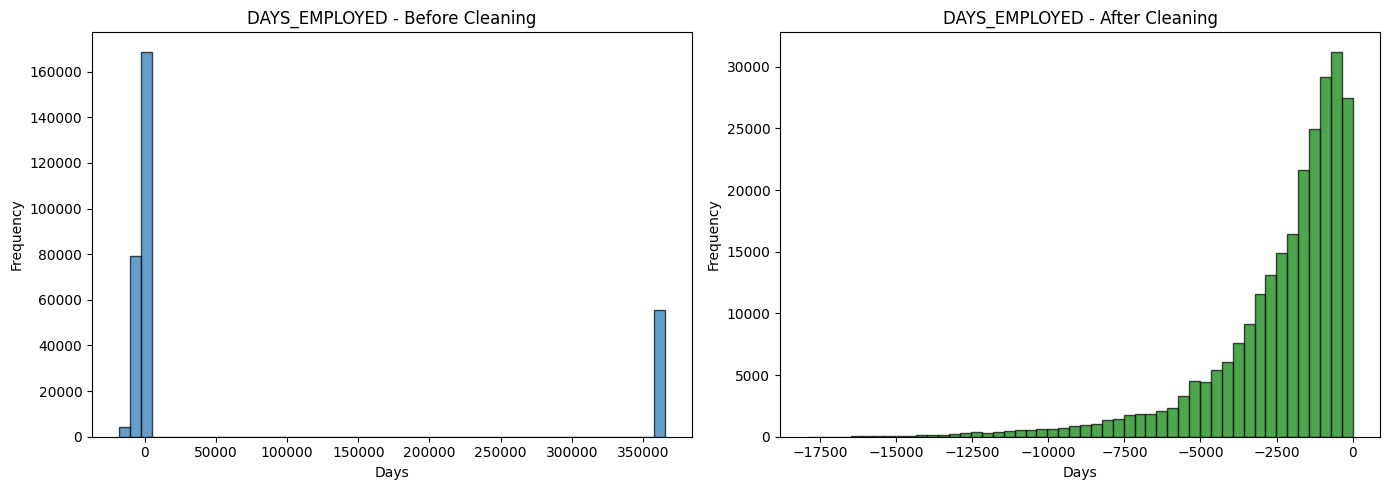

In [30]:
# ตรวจสอบหลังแก้ไข
print(" DAYS_EMPLOYED Statistics (After):")
print(app_train_clean['DAYS_EMPLOYED'].describe())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before (Original)
axes[0].hist(app_train['DAYS_EMPLOYED'].dropna(), bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('DAYS_EMPLOYED - Before Cleaning')
axes[0].set_xlabel('Days')
axes[0].set_ylabel('Frequency')

# After (Cleaned)
axes[1].hist(app_train_clean['DAYS_EMPLOYED'].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1].set_title('DAYS_EMPLOYED - After Cleaning')
axes[1].set_xlabel('Days')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### 4.3 Impute Missing Values

In [31]:
def impute_missing_values(df):
    """
    Impute missing values:
    - Numeric: Median
    - Categorical: Mode
    """
    df_imputed = df.copy()
    
    # Numeric columns - impute with median
    numeric_cols = df_imputed.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_imputed[col].isnull().any():
            median_val = df_imputed[col].median()
            df_imputed[col].fillna(median_val, inplace=True)
    
    # Categorical columns - impute with mode
    cat_cols = df_imputed.select_dtypes(include=['object']).columns
    for col in cat_cols:
        if df_imputed[col].isnull().any():
            if not df_imputed[col].mode().empty:
                mode_val = df_imputed[col].mode()[0]
                df_imputed[col].fillna(mode_val, inplace=True)
            else:
                df_imputed[col].fillna('Unknown', inplace=True)
    
    return df_imputed

# Impute missing values
print("Imputing missing values...")

missing_before = app_train_clean.isnull().sum().sum()
app_train_clean = impute_missing_values(app_train_clean)
missing_after = app_train_clean.isnull().sum().sum()

print(f"   Missing values before: {missing_before}")
print(f"   Missing values after: {missing_after}")

# ทำเช่นเดียวกันกับ test data
app_test_clean = impute_missing_values(app_test_clean)

print("\n Missing values imputed successfully!")

Imputing missing values...
   Missing values before: 9207839
   Missing values after: 0

 Missing values imputed successfully!


---
## 5. Feature Aggregation จากตารางเสริม

### 5.1 Aggregate Bureau Data

In [32]:
def agg_numeric(df, group_col, prefix):
    """
    Aggregate numeric columns by group.
    
    Parameters:
    - df: DataFrame
    - group_col: Column to group by
    - prefix: Prefix for new column names
    """
    # Select numeric columns (exclude ID columns)
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [c for c in numeric_cols if c != group_col and 'SK_ID' not in c]
    
    # Aggregation functions
    agg_funcs = ['count', 'mean', 'max', 'min', 'sum', 'std']
    
    # Aggregate
    agg_df = df.groupby(group_col)[numeric_cols].agg(agg_funcs)
    
    # Flatten column names
    agg_df.columns = [f"{prefix}_{col}_{stat}" for col, stat in agg_df.columns]
    
    # Reset index
    agg_df = agg_df.reset_index()
    
    return agg_df

print(" กำลัง Aggregate Bureau Data...")
bureau_agg = agg_numeric(bureau, 'SK_ID_CURR', 'BUREAU')
print(f"   Bureau Aggregated Shape: {bureau_agg.shape}")
print(f"   Sample columns: {bureau_agg.columns[:5].tolist()}")

 กำลัง Aggregate Bureau Data...
   Bureau Aggregated Shape: (305811, 73)
   Sample columns: ['SK_ID_CURR', 'BUREAU_DAYS_CREDIT_count', 'BUREAU_DAYS_CREDIT_mean', 'BUREAU_DAYS_CREDIT_max', 'BUREAU_DAYS_CREDIT_min']


### 5.2 Aggregate Previous Application Data

In [33]:
print(" กำลัง Aggregate Previous Application Data...")
prev_agg = agg_numeric(prev_app, 'SK_ID_CURR', 'PREV')
print(f"   Previous Application Aggregated Shape: {prev_agg.shape}")
print(f"   Sample columns: {prev_agg.columns[:5].tolist()}")

 กำลัง Aggregate Previous Application Data...
   Previous Application Aggregated Shape: (338857, 115)
   Sample columns: ['SK_ID_CURR', 'PREV_AMT_ANNUITY_count', 'PREV_AMT_ANNUITY_mean', 'PREV_AMT_ANNUITY_max', 'PREV_AMT_ANNUITY_min']


### 5.3 Aggregate POS CASH Balance

In [34]:
print(" กำลัง Aggregate POS CASH Balance...")
pos_agg = agg_numeric(pos_cash, 'SK_ID_CURR', 'POS')
print(f"   POS CASH Aggregated Shape: {pos_agg.shape}")
print(f"   Sample columns: {pos_agg.columns[:5].tolist()}")

 กำลัง Aggregate POS CASH Balance...
   POS CASH Aggregated Shape: (337252, 31)
   Sample columns: ['SK_ID_CURR', 'POS_MONTHS_BALANCE_count', 'POS_MONTHS_BALANCE_mean', 'POS_MONTHS_BALANCE_max', 'POS_MONTHS_BALANCE_min']


### 5.4 Aggregate Credit Card Balance

In [35]:
print(" กำลัง Aggregate Credit Card Balance...")
cc_agg = agg_numeric(credit_card, 'SK_ID_CURR', 'CC')
print(f"   Credit Card Aggregated Shape: {cc_agg.shape}")
print(f"   Sample columns: {cc_agg.columns[:5].tolist()}")

 กำลัง Aggregate Credit Card Balance...
   Credit Card Aggregated Shape: (103558, 121)
   Sample columns: ['SK_ID_CURR', 'CC_MONTHS_BALANCE_count', 'CC_MONTHS_BALANCE_mean', 'CC_MONTHS_BALANCE_max', 'CC_MONTHS_BALANCE_min']


### 5.5 Aggregate Installments Payments

In [36]:
print(" กำลัง Aggregate Installments Payments...")
install_agg = agg_numeric(installments, 'SK_ID_CURR', 'INSTALL')
print(f"   Installments Aggregated Shape: {install_agg.shape}")
print(f"   Sample columns: {install_agg.columns[:5].tolist()}")

 กำลัง Aggregate Installments Payments...
   Installments Aggregated Shape: (339587, 37)
   Sample columns: ['SK_ID_CURR', 'INSTALL_NUM_INSTALMENT_VERSION_count', 'INSTALL_NUM_INSTALMENT_VERSION_mean', 'INSTALL_NUM_INSTALMENT_VERSION_max', 'INSTALL_NUM_INSTALMENT_VERSION_min']


---
## 6. Joining ข้อมูลทั้งหมด

### 6.1 Merge Training Data

In [37]:
print(" กำลัง Merge Training Data...")
print(f"   Base shape: {app_train_clean.shape}")

# Merge ทีละตาราง
train_merged = app_train_clean.merge(bureau_agg, on='SK_ID_CURR', how='left')
print(f"   After Bureau merge: {train_merged.shape}")

train_merged = train_merged.merge(prev_agg, on='SK_ID_CURR', how='left')
print(f"   After Previous App merge: {train_merged.shape}")

train_merged = train_merged.merge(pos_agg, on='SK_ID_CURR', how='left')
print(f"   After POS CASH merge: {train_merged.shape}")

train_merged = train_merged.merge(cc_agg, on='SK_ID_CURR', how='left')
print(f"   After Credit Card merge: {train_merged.shape}")

train_merged = train_merged.merge(install_agg, on='SK_ID_CURR', how='left')
print(f"   After Installments merge: {train_merged.shape}")

print("\n Training data merged successfully!")

 กำลัง Merge Training Data...
   Base shape: (307511, 123)
   After Bureau merge: (307511, 195)
   After Previous App merge: (307511, 309)
   After POS CASH merge: (307511, 339)
   After Credit Card merge: (307511, 459)
   After Installments merge: (307511, 495)

 Training data merged successfully!


### 6.2 Merge Test Data

In [38]:
print(" กำลัง Merge Test Data...")
print(f"   Base shape: {app_test_clean.shape}")

# Merge ทีละตาราง
test_merged = app_test_clean.merge(bureau_agg, on='SK_ID_CURR', how='left')
print(f"   After Bureau merge: {test_merged.shape}")

test_merged = test_merged.merge(prev_agg, on='SK_ID_CURR', how='left')
print(f"   After Previous App merge: {test_merged.shape}")

test_merged = test_merged.merge(pos_agg, on='SK_ID_CURR', how='left')
print(f"   After POS CASH merge: {test_merged.shape}")

test_merged = test_merged.merge(cc_agg, on='SK_ID_CURR', how='left')
print(f"   After Credit Card merge: {test_merged.shape}")

test_merged = test_merged.merge(install_agg, on='SK_ID_CURR', how='left')
print(f"   After Installments merge: {test_merged.shape}")

print("\n Test data merged successfully!")

 กำลัง Merge Test Data...
   Base shape: (48744, 122)
   After Bureau merge: (48744, 194)
   After Previous App merge: (48744, 308)
   After POS CASH merge: (48744, 338)
   After Credit Card merge: (48744, 458)
   After Installments merge: (48744, 494)

 Test data merged successfully!


### 6.3 Handle New Missing Values from Joins

In [39]:
print(" Handling missing values from joins...")

# ตรวจสอบ missing values ที่เกิดจาก left join
missing_train_merged = train_merged.isnull().sum().sum()
print(f"   Missing values in train after merge: {missing_train_merged}")

# Fill missing values with 0 (เพราะไม่มีข้อมูลในตารางเสริม)
train_merged = train_merged.fillna(0)
test_merged = test_merged.fillna(0)

print(f"   Missing values in train after fill: {train_merged.isnull().sum().sum()}")
print(f"   Missing values in test after fill: {test_merged.isnull().sum().sum()}")

print("\n Missing values handled!")

 Handling missing values from joins...
   Missing values in train after merge: 38840445
   Missing values in train after fill: 0
   Missing values in test after fill: 0

 Missing values handled!


---
## 7. Data Validation & Summary

In [40]:
print("="*60)
print(" FINAL DATA SUMMARY")
print("="*60)

print(f"\n Training Data:")
print(f"   Shape: {train_merged.shape}")
print(f"   Memory Usage: {train_merged.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"   Target Distribution:")
print(train_merged['TARGET'].value_counts(normalize=True))

print(f"\n Test Data:")
print(f"   Shape: {test_merged.shape}")
print(f"   Memory Usage: {test_merged.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

 FINAL DATA SUMMARY

 Training Data:
   Shape: (307511, 495)
   Memory Usage: 1397.47 MB
   Target Distribution:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

 Test Data:
   Shape: (48744, 494)
   Memory Usage: 221.11 MB


In [41]:
# ดูโครงสร้างข้อมูล
print("\n Data Types Summary (Train):")
print(train_merged.dtypes.value_counts())

print("\n Sample of Merged Data:")
display(train_merged.head())


 Data Types Summary (Train):
float64    438
int64       40
object      16
bool         1
Name: count, dtype: int64

 Sample of Merged Data:


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,CC_CNT_INSTALMENT_MATURE_CUM_sum,CC_CNT_INSTALMENT_MATURE_CUM_std,CC_SK_DPD_count,CC_SK_DPD_mean,CC_SK_DPD_max,CC_SK_DPD_min,CC_SK_DPD_sum,CC_SK_DPD_std,CC_SK_DPD_DEF_count,CC_SK_DPD_DEF_mean,CC_SK_DPD_DEF_max,CC_SK_DPD_DEF_min,CC_SK_DPD_DEF_sum,CC_SK_DPD_DEF_std,INSTALL_NUM_INSTALMENT_VERSION_count,INSTALL_NUM_INSTALMENT_VERSION_mean,INSTALL_NUM_INSTALMENT_VERSION_max,INSTALL_NUM_INSTALMENT_VERSION_min,INSTALL_NUM_INSTALMENT_VERSION_sum,INSTALL_NUM_INSTALMENT_VERSION_std,INSTALL_NUM_INSTALMENT_NUMBER_count,INSTALL_NUM_INSTALMENT_NUMBER_mean,INSTALL_NUM_INSTALMENT_NUMBER_max,INSTALL_NUM_INSTALMENT_NUMBER_min,INSTALL_NUM_INSTALMENT_NUMBER_sum,INSTALL_NUM_INSTALMENT_NUMBER_std,INSTALL_DAYS_INSTALMENT_count,INSTALL_DAYS_INSTALMENT_mean,INSTALL_DAYS_INSTALMENT_max,INSTALL_DAYS_INSTALMENT_min,INSTALL_DAYS_INSTALMENT_sum,INSTALL_DAYS_INSTALMENT_std,INSTALL_DAYS_ENTRY_PAYMENT_count,INSTALL_DAYS_ENTRY_PAYMENT_mean,INSTALL_DAYS_ENTRY_PAYMENT_max,INSTALL_DAYS_ENTRY_PAYMENT_min,INSTALL_DAYS_ENTRY_PAYMENT_sum,INSTALL_DAYS_ENTRY_PAYMENT_std,INSTALL_AMT_INSTALMENT_count,INSTALL_AMT_INSTALMENT_mean,INSTALL_AMT_INSTALMENT_max,INSTALL_AMT_INSTALMENT_min,INSTALL_AMT_INSTALMENT_sum,INSTALL_AMT_INSTALMENT_std,INSTALL_AMT_PAYMENT_count,INSTALL_AMT_PAYMENT_mean,INSTALL_AMT_PAYMENT_max,INSTALL_AMT_PAYMENT_min,INSTALL_AMT_PAYMENT_sum,INSTALL_AMT_PAYMENT_std
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637.0,-3648.0,-2120,9.0,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19.0,1.052632,2.0,1.0,20.0,0.229416,19.0,10.000000,19.0,1.0,190.0,5.627314,19.0,-295.000000,-25.0,-565.0,-5605.0,168.819430,19.0,-315.421053,-49.0,-587.0,-5993.0,172.058877,19.0,11559.247105,53093.745,9251.775,219625.695,10058.037722,19.0,11559.247105,53093.745,9251.775,219625.695,10058.037722
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188.0,-1186.0,-291,9.0,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,0.535276,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,25.0,1.040000,2.0,1.0,26.0,0.200000,25.0,5.080000,12.0,1.0,127.0,3.134751,25.0,-1378.160000,-536.0,-2310.0,-34454.0,757.453556,25.0,-1385.320000,-544.0,-2324.0,-34633.0,757.325432,25.0,64754.586000,560835.360,6662.970,1618864.650,110542.592300,25.0,64754.586000,560835.360,6662.970,1618864.650,110542.592300
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225.0,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,0.505998,0.555912,0.729567,0.0876,0.0763,0.9816,0.7552,0.0211,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.333333,2.0,1.0,4.0,0

---
## 8. บันทึกข้อมูลที่ประมวลผลแล้ว

In [42]:
# บันทึกเป็น CSV
print(" กำลังบันทึกข้อมูล...")

train_path = os.path.join(DATA_PROCESSED, "train_cleaned.csv")
test_path = os.path.join(DATA_PROCESSED, "test_cleaned.csv")

train_merged.to_csv(train_path, index=False)
print(f"  Saved: {train_path}")

test_merged.to_csv(test_path, index=False)
print(f"  Saved: {test_path}")

print("\n Data Cleaning & Joining เสร็จสมบูรณ์!")

 กำลังบันทึกข้อมูล...
  Saved: ../data/processed\train_cleaned.csv
  Saved: ../data/processed\test_cleaned.csv

 Data Cleaning & Joining เสร็จสมบูรณ์!


In [44]:
# บันทึก Aggregated Data แยก (optional)
print(" กำลังบันทึก Aggregated Data...")

bureau_agg.to_csv(os.path.join(DATA_PROCESSED, "bureau_agg.csv"), index=False)
prev_agg.to_csv(os.path.join(DATA_PROCESSED, "prev_agg.csv"), index=False)
pos_agg.to_csv(os.path.join(DATA_PROCESSED, "pos_agg.csv"), index=False)
cc_agg.to_csv(os.path.join(DATA_PROCESSED, "cc_agg.csv"), index=False)
install_agg.to_csv(os.path.join(DATA_PROCESSED, "install_agg.csv"), index=False)

print(" Aggregated data saved!")

 กำลังบันทึก Aggregated Data...
 Aggregated data saved!
